## Checking Existence of Spark Environment Variables

Make sure your notebook is loaded using a PySpark Workspace. If you open up a regular Jupyter workspace the following variables might not exist

In [1]:
spark

NameError: name 'spark' is not defined

In [5]:
sqlContext

NameError: name 'sqlContext' is not defined

### Run the following if you failed to open a notebook in the PySpark Workspace

This will work assuming you are using Spark in the cloud on domino or you might need to configure with your own spark instance if you are working offline

In [7]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

## Create a utility function to run SQL commands

Instead of typing the same python functions repeatedly, we build a small function where you can just pass your query to get results.

- Remember we are using Spark SQL in PySpark
- We can't run multiple SQL statements in one go (no semi-colon ';' separated SQL statements)
- We can run multi-line SQL queries (but still has to be a single statement)

In [8]:
def run_sql(statement):
    try:
        result = sqlContext.sql(statement)
    except Exception as e:
        print(e.desc, '\n', e.stackTrace)
        return
    return result

In [9]:
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary


In [10]:
run_sql('drop table if exists adult')

DataFrame[]

# Loading the Dataset

Below we will use Spark SQL to load in the data and then register it as a Dataframe. So the end result will be a Spark SQL table called `adult` and a Spark Dataframe called `adult_df`. 

This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with. 

When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

## Creating the DataFrame

In this section, we will be creating a spark dataframe from the `adult` dataset which is easier work with when building machine learning models.

To get started, first make sure you have already uploaded the `adult.data.csv` CSV file and it is present in the same directory as the notebook.

Once you have done this, please remember to execute the following code to build the dataframe which can also be accessed as a table using spark SQL which we will see shortly.

In [11]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

# File location and type
file_location_adult = "./adult.data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# define the schema based on the dataset dictionary
# this is available here: https://archive.ics.uci.edu/ml/datasets/adult
schema = StructType([
      StructField('age', DoubleType()),
      StructField('workclass', StringType()),
      StructField('fnlwgt', DoubleType()),
      StructField('education', StringType()),
      StructField('education_num', DoubleType()),
      StructField('marital_status', StringType()),
      StructField('occupation', StringType()),
      StructField('relationship', StringType()),
      StructField('race', StringType()),
      StructField('sex', StringType()),
      StructField('capital_gain', DoubleType()),
      StructField('capital_loss', DoubleType()),
      StructField('hours_per_week', DoubleType()),
      StructField('native_country', StringType()),
      StructField('income', StringType())
])


# The applied options are for CSV files. For other file types, these will be ignored.
adult_df = (spark.read.format(file_type) 
                    .schema(schema)
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_location_adult))

### Viewing the dataframe schemas

We can take a look at the schemas of our potential dataset

In [12]:
print('Adult Dataset Schema')
adult_df.printSchema()

Adult Dataset Schema
root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
adult_df.registerTempTable("adult")
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,adult,True


# Viewing the Dataset

In [14]:
df = run_sql("SELECT * FROM adult LIMIT 5")
df.toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes. 

In [15]:
result = run_sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
result.toPandas()

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Prof-specialty,4140,0.53,0.02,0.13,0.02,0.30
1,Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
2,Exec-managerial,4066,0.61,0.02,0.15,0.02,0.20
3,Adm-clerical,3770,0.28,0.04,0.22,0.04,0.42
4,Sales,3650,0.47,0.03,0.12,0.03,0.36
5,Other-service,3295,0.24,0.05,0.15,0.06,0.50
6,Machine-op-inspct,2002,0.51,0.03,0.14,0.04,0.29
7,?,1843,0.36,0.08,0.10,0.04,0.42
8,Transport-moving,1597,0.63,0.02,0.11,0.02,0.21
9,Handlers-cleaners,1370,0.36,0.01,0.09,0.03,0.51


You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL as needed.  

In [16]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,adult,True
1,,result,True


In [17]:
run_sql("SELECT * FROM result").limit(5).toPandas()

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Prof-specialty,4140,0.53,0.02,0.13,0.02,0.30
1,Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
2,Exec-managerial,4066,0.61,0.02,0.15,0.02,0.20
3,Adm-clerical,3770,0.28,0.04,0.22,0.04,0.42
4,Sales,3650,0.47,0.03,0.12,0.03,0.36


# Your Turn: Q1
### Write some Spark SQL to get the top 'bachelor_rate' by 'education' group?

In [18]:
### Q1 Answer ###

# I'm interpretting the questino as get top education group with highest bachelor_rate

result = run_sql(
  """
  select * from (
      select education, ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
      from adult
      group by education
      order by bachelor_rate desc
  ) limit 1
  """)
result.show()

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+



# Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [19]:
# register a df from the sql df
adult_df = spark.table("adult")
cols = adult_df.columns # this will be used much later in the notebook, ignore for now
print(type(adult_df))
print(cols)

<class 'pyspark.sql.dataframe.DataFrame'>
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [20]:
# look at df schema
adult_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



Be careful with `toPandas()` since it dumps the entire spark dataframe (which might be distributed) in your local system which might end up crashing your notebook if your resources can't handle it. A good option is always to use `limit()` to limit the rows and then take a look at the data.

In [21]:
adult_df.limit(5).toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Using the DataFrame API for computations

By now, you have already learnt how to leverage the Spark DataFrame API to wrangle, aggregate, filter and transform data. Following is a depiction on our dataset showcasing the divorced date based on occupation

In [22]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = adult_df.select(
  adult_df['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
| Exec-managerial|         0.15|
|   Other-service|         0.15|
|    Tech-support|         0.15|
+----------------+-------------+
only showing top 5 rows



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.

But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

# Your Turn: Q2
### Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [23]:
### Q2 Answer ###

df_result = adult_df.select(
    adult_df['education'],
    when( col('marital_status') == ' Never-married' , 1 ).otherwise(0).alias('is_bachelor')

)
df_result = df_result.groupBy('education').agg(round(mean('is_bachelor'), 2).alias('bachelor_rate'))
df_result = df_result.orderBy(desc('bachelor_rate'))
df_result.show(1)


+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+
only showing top 1 row



## Explore & Visualize Data
It's very easy to convert your Spark DataFrame into a Pandas dataframe and then continue to analyse or plot as you might normally.  We have depicted the same in several example above. You can also use the `collect()` function if needed instead of `toPandas()` but you would need to call a `pandas.DataFrame` on the result.

Obviously if you try to build a huge pandas DataFrame then you will run into issues, so usually the best practice is to only collect aggregated or sampled data into a Pandas df.

In [24]:
import pandas as pd

# do some analysis
result = run_sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

df_pandas.head()

,occupation,plus_50k
0,Exec-managerial,0.484014
1,Prof-specialty,0.449034
2,Protective-serv,0.325116
3,Tech-support,0.304957
4,Sales,0.269315


In [25]:
# or just use a one-liner for a pandas df
df_pandas = result.toPandas()
df_pandas.head()

,occupation,plus_50k
0,Exec-managerial,0.484014
1,Prof-specialty,0.449034
2,Protective-serv,0.325116
3,Tech-support,0.304957
4,Sales,0.269315


In [26]:
df_pandas.describe()

,plus_50k
count,15.000000
mean,0.197354
std,0.143994
min,0.006711
25%,0.107373
50%,0.134483
75%,0.287136
max,0.484014


In [27]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
occupation    15 non-null object
plus_50k      15 non-null float64
dtypes: float64(1), object(1)
memory usage: 320.0+ bytes


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this as pretty as you want). 

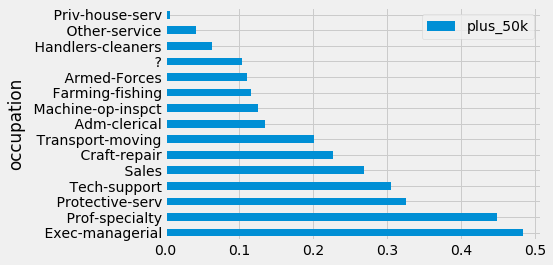

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# feel free to chose your own style!
plt.style.use('fivethirtyeight')

# get simple plot on the pandas data
df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.

So this is an example of when you might want to move from Spark SQL into using DataFrames API as being able to just call `describe()` on the Spark DF is easier then trying to do the equivalent in Spark SQL.

In [29]:
# describe df
adult_df.select(adult_df['age'], adult_df['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             32561|            32561|
|   mean| 38.58164675532078| 10.0806793403151|
| stddev|13.640432553581356|2.572720332067397|
|    min|              17.0|              1.0|
|    max|              90.0|             16.0|
+-------+------------------+-----------------+



## ML Pipeline - Logistic Regression vs Random Forest

Below we will create two Spark ML Pipelines - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

We will be using Spark MLlib. Here are some interesting facts about the same and you can read up more in the [official docs](https://spark.apache.org/docs/latest/ml-guide.html)

#### What is MLlib?
MLlib is Spark’s machine learning (ML) library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

Some important points to remember.

#### The MLlib RDD-based API is now in maintenance mode.
As of Spark 2.0, the RDD-based APIs in the `spark.mllib` package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the `spark.ml` package.

#### Why is MLlib switching to the DataFrame-based API?
DataFrames provide a more user-friendly API than RDDs. The many benefits of DataFrames include Spark Datasources, SQL/DataFrame queries, Tungsten and Catalyst optimizations, and uniform APIs across languages.
The DataFrame-based API for MLlib provides a uniform API across ML algorithms and across multiple languages.
DataFrames facilitate practical ML Pipelines, particularly feature transformations. See the Pipelines guide for details.

#### What is “Spark ML”?
“Spark ML” is not an official name but occasionally used to refer to the MLlib DataFrame-based API. This is majorly due to the org.apache.spark.ml Scala package name used by the DataFrame-based API, and the “Spark ML Pipelines” term we used initially to emphasize the pipeline concept.

#### Is MLlib deprecated?
No. MLlib includes both the RDD-based API and the DataFrame-based API. The RDD-based API is now in maintenance mode. But neither API is deprecated, nor MLlib as a whole.

In [30]:
import pyspark
pyspark.__version__

'2.4.3'

In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [32]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [33]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [34]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(adult_df)
dataset = pipelineModel.transform(adult_df)

# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.limit(10).toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",49.0,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",52.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.0,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [35]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22838
9723


In [36]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23933794552938087


# Logistic Regression - Training

In [37]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = (fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)'])
                           .select('threshold').head()['threshold'])
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.3501591272080348


# Logistic Regression - Predictions

In [38]:
# check current model prediction threshold
lrModel._java_obj.getThreshold()

0.23933794552938087

In [39]:
# rebuild model with optimal threshold from training
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(lrBestThreshold)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

lrModel._java_obj.getThreshold()

0.3501591272080348

In [40]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").limit(10).toPandas()

,label,prediction,probability
0,0.0,0.0,"[0.6923453279519433, 0.3076546720480568]"
1,0.0,1.0,"[0.6211553145296423, 0.37884468547035766]"
2,0.0,0.0,"[0.6584529417752994, 0.3415470582247006]"
3,0.0,0.0,"[0.6582662002284263, 0.34173379977157375]"
4,0.0,1.0,"[0.6150342380572296, 0.3849657619427704]"
5,0.0,1.0,"[0.5398608213408302, 0.46013917865916976]"
6,0.0,1.0,"[0.6004473238924508, 0.39955267610754913]"
7,0.0,1.0,"[0.589862498197214, 0.41013750180278596]"
8,0.0,1.0,"[0.5824187454881695, 0.4175812545118305]"
9,0.0,1.0,"[0.5920153502136111, 0.407984649786389]"


# Gradient Boosting Machines (GBM) - Training

Here you will train your own GBM Classifier and make predictions

# Your Turn: Q3
### Train a GBTClassifier on the training data, call the trained model 'gbModel'
- Note: You don't need to set a prediction threshold here, just try training a vanilla GBM model

In [41]:
from pyspark.ml.classification import GBTClassifier
gbt =  GBTClassifier(featuresCol='features', labelCol='label', maxIter=5, seed=1)
gbModel = gbt.fit(trainingData)

# Your Turn: Q4
### Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions' and display the first 10 records

In [42]:
# make predictions on test data
gbPredictions = gbModel.transform(testData)


# display predictions
gbPredictions.select("label", "prediction", "probability").limit(10).toPandas()

,label,prediction,probability
0,0.0,0.0,"[0.7815552584204344, 0.21844474157956562]"
1,0.0,0.0,"[0.7625892432679594, 0.2374107567320406]"
2,0.0,0.0,"[0.7625892432679594, 0.2374107567320406]"
3,0.0,0.0,"[0.7416622890053174, 0.2583377109946826]"
4,0.0,0.0,"[0.5676783670701522, 0.4323216329298478]"
5,0.0,0.0,"[0.5676783670701522, 0.4323216329298478]"
6,0.0,0.0,"[0.5996087024899495, 0.40039129751005054]"
7,0.0,0.0,"[0.5996087024899495, 0.40039129751005054]"
8,0.0,0.0,"[0.62785873287545, 0.37214126712455]"
9,0.0,0.0,"[0.62785873287545, 0.37214126712455]"


# Model Performance Evaluation

Without evaluation of how our models perform, there is no way for us to find out which model might be better or more suitable to solving a specific problem. Let's spend some time evaluating our models.

# Your Turn: Q5 - Logistic Regression - Evaluation

### Complete the `print_performance_metrics()` function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("auc = {}".format(auc))
    print("aupr = {}".format(aupr))

    # get rdd of predictions and labels for mllib eval metrics
    predictionAndLabels = predictions.select("prediction","label").rdd

    # Instantiate metrics objects
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    multi_metrics = MulticlassMetrics(predictionAndLabels)

    # Area under precision-recall curve
    print("Area under PR = {}".format(binary_metrics.areaUnderPR))
    # Area under ROC curve
    print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
    # Accuracy
    print("Accuracy = {}".format(multi_metrics.accuracy))
    # Confusion Matrix
    print(multi_metrics.confusionMatrix())

    ### Question 5.1 Answer ###

    # F1
    print("F1 = {}".format((multi_metrics.fMeasure(0.0) + multi_metrics.fMeasure(1.0))/ 2))
    # Precision
    print("Precision = {}".format((multi_metrics.precision(0.0) + multi_metrics.precision(1.0))/ 2))
    # Recall
    print("Recall = {}".format((multi_metrics.recall(0.0) + multi_metrics.recall(1.0))/ 2))
    # FPR
    print("FPR = {}".format((multi_metrics.falsePositiveRate(0.0) + multi_metrics.falsePositiveRate(1.0))/ 2))
    # TPR
    print("TPR = {}".format((multi_metrics.truePositiveRate(0.0) + multi_metrics.truePositiveRate(1.0))/ 2))
  
  
print_performance_metrics(lrPredictions)

auc = 0.9014206228690932
aupr = 0.761946969391458
Area under PR = 0.5875787495140637
Area under ROC = 0.8018978884336591
Accuracy = 0.8343103980253008
DenseMatrix([[6358.,  990.],
             [ 621., 1754.]])
F1 = 0.7864225309348267
Precision = 0.7751157992929225
Recall = 0.801897888433659
FPR = 0.198102111566341
TPR = 0.801897888433659


# Your Turn: Q6 - GBM - Evaluation

### Now use the `print_performance_metrics()` function to evaluate the performance of the GBM model and compare the results

In [44]:
print_performance_metrics(gbPredictions)

auc = 0.896934389594018
aupr = 0.7656896807744206
Area under PR = 0.6430310879708558
Area under ROC = 0.7513783055897774
Accuracy = 0.8484006993726216
DenseMatrix([[6915.,  433.],
             [1041., 1334.]])
F1 = 0.7739092899909965
Precision = 0.8120536251590881
Recall = 0.7513783055897774
FPR = 0.2486216944102226
TPR = 0.7513783055897774


# Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [45]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [46]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

# Logistic Regression - Param Grid

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.5, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
               .addGrid(lr.maxIter, [2, 5])
               .build())

In [48]:
print('Total Models (with all hyperparameter combinations):', len(lrParamGrid))

Total Models (with all hyperparameter combinations): 18


# Your Turn: Q7: GBM - Param Grid
Build out a param grid for the gb model, call it 'gbParamGrid'.

In [49]:
gbParamGrid = (ParamGridBuilder()
              .addGrid(gbt.maxDepth, [3, 5, 10])
              .addGrid(gbt.maxBins, [16, 32, 64])
              .addGrid(gbt.stepSize, [0.1, 1])
              .build())

# Logistic Regression - Perform Cross Validation

In [50]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [51]:
# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


In [52]:
lrCvModel.bestModel._java_obj.extractParamMap()

JavaObject id=o14686

# Your Turn: Q8: GBM - Perform Cross Validation
- Perform cross validation of params on your 'gb' model.
- Print out the best params you found.

In [53]:
# Create CrossValidator
gbCv = CrossValidator(estimator=gbt, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=3)


# Run cross validations
gbCvModel = gbCv.fit(trainingData)


In [54]:
# look at best params from the CV
gbCvModel.bestModel._java_obj.extractParamMap()

JavaObject id=o29336

# Logistic Regression - CV Model Predict

In [55]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.limit(10).toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.2486928032823581, -0.2486928032823581]","[0.5618547291139451, 0.4381452708860548]",1.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"[0.2276446624773114, -0.2276446624773114]","[0.5566666613069821, 0.4433333386930179]",1.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",31.0,Private,62374.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.23099943840427395, -0.23099943840427395]","[0.5574944245950947, 0.4425055754049054]",1.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,32732.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.2046030086772801, -0.2046030086772801]","[0.5509730549490336, 0.44902694505096646]",1.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.31074633033305255, -0.31074633033305255]","[0.5770674214392942, 0.4229325785607058]",1.0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",47.0,Private,76612.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.1755857663178706, -0.1755857663178706]","[0.5437840096023354, 0.45621599039766453]",1.0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.21323631793825948, -0.21323631793825948]","[0.5531079979717417, 0.4468920020282583]",1.0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",51.0,Private,95469.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.21956089063506967, -0.21956089063506967]","[0.5546707728226024, 0.44532922717739765]",1.0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.3062724370035119, -0.3062724370035119]","[0.5759751455073088, 0.4240248544926912]",1.0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",61.0,Private,128230.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.24918903544206006, -0.24918903544206006]","[0.561976884813908, 0.438023115186092]",1.0


# GBM - CV Model Predict

In [56]:
gbCvPredictions = gbCvModel.transform(testData)

gbCvPredictions.limit(10).toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.8971564065620593, -0.8971564065620593]","[0.8574552264755075, 0.14254477352449246]",0.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"[0.7444172324415942, -0.7444172324415942]","[0.8159032676880169, 0.1840967323119831]",0.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",31.0,Private,62374.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.7444172324415942, -0.7444172324415942]","[0.8159032676880169, 0.1840967323119831]",0.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,32732.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.7444172324415942, -0.7444172324415942]","[0.8159032676880169, 0.1840967323119831]",0.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.3536815334250144, -0.3536815334250144]","[0.6698182323837413, 0.3301817676162587]",0.0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",47.0,Private,76612.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.08775553002965025, -0.08775553002965025]","[0.5437654761919282, 0.45623452380807183]",0.0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.16865606631089997, -0.16865606631089997]","[0.583537460423238, 0.41646253957676205]",0.0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",51.0,Private,95469.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.16865606631089997, -0.16865606631089997]","[0.583537460423238, 0.41646253957676205]",0.0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.9059294874367994, -0.9059294874367994]","[0.8595863981340147, 0.14041360186598528]",0.0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",61.0,Private,128230.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.9059294874367994, -0.9059294874367994]","[0.8595863981340147, 0.14041360186598528]",0.0


# Logistic Regression - CV Model Evaluate

In [57]:
print_performance_metrics(lrCvPredictions)

auc = 0.8842508666877075
aupr = 0.7249199987821793
Area under PR = 0.5656886414414127
Area under ROC = 0.7798798384093057
Accuracy = 0.8229970173814666
DenseMatrix([[6350.,  998.],
             [ 723., 1652.]])
F1 = 0.7690862931028237
Precision = 0.7605882588317519
Recall = 0.7798798384093057
FPR = 0.2201201615906942
TPR = 0.7798798384093057


# GBM - CV Model Evaluate

In [58]:
print_performance_metrics(gbCvPredictions)

auc = 0.90957619688852
aupr = 0.7857583453377894
Area under PR = 0.6506691173811558
Area under ROC = 0.788339884823654
Accuracy = 0.8579656484624087
DenseMatrix([[6793.,  555.],
             [ 826., 1549.]])
F1 = 0.7997012941756079
Precision = 0.8139017762278314
Recall = 0.7883398848236541
FPR = 0.21166011517634586
TPR = 0.7883398848236541


# Logistic Regression - Model Exploration

In [59]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -1.2494013222176612


In [60]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.toPandas().T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Feature Weight,-0.222875,-0.353262,-0.139326,-0.469727,-0.257647,0.431061,0.404956,-1.15874,-0.43939,-0.193904,...,-0.96918,-0.837257,-1.000815,-0.44414,0.004132,-7.511191e-07,0.023957,0.000048,0.000455,0.004634


# Computing Feature Importance

Interpreting machine learning models is always a thing of paramount importance with business stakeholders always wanting to know how machine learning models really work. Feature importances can be an interesting way to tackle this problem. Let's explore how to find feature importances for our models. 

# Your Turn: Q9: Print out a table of feature_name and feature_coefficient from the Logistic Regression model 

- Hint: Adapt the code from [here](https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name) if needed as a reference.

In [61]:
from itertools import chain

# attrs = sorted(
#     (attr["idx"], attr["name"]) for attr in 
#     chain(*dataset.schema["features"].metadata["ml_attr"]["attrs"].values()))

# get the index and names so we can use dict to rename indexes
attrs = \
    {attr["idx"]: attr["name"] for attr in 
    chain(*dataset.schema["features"].metadata["ml_attr"]["attrs"].values())}

In [80]:
attrs

{94: 'age',
 95: 'fnlwgt',
 96: 'education_num',
 97: 'capital_gain',
 98: 'capital_loss',
 99: 'hours_per_week',
 0: 'workclassclassVec_ Private',
 1: 'workclassclassVec_ Self-emp-not-inc',
 2: 'workclassclassVec_ Local-gov',
 3: 'workclassclassVec_ ?',
 4: 'workclassclassVec_ State-gov',
 5: 'workclassclassVec_ Self-emp-inc',
 6: 'workclassclassVec_ Federal-gov',
 7: 'workclassclassVec_ Without-pay',
 8: 'educationclassVec_ HS-grad',
 9: 'educationclassVec_ Some-college',
 10: 'educationclassVec_ Bachelors',
 11: 'educationclassVec_ Masters',
 12: 'educationclassVec_ Assoc-voc',
 13: 'educationclassVec_ 11th',
 14: 'educationclassVec_ Assoc-acdm',
 15: 'educationclassVec_ 10th',
 16: 'educationclassVec_ 7th-8th',
 17: 'educationclassVec_ Prof-school',
 18: 'educationclassVec_ 9th',
 19: 'educationclassVec_ 12th',
 20: 'educationclassVec_ Doctorate',
 21: 'educationclassVec_ 5th-6th',
 22: 'educationclassVec_ 1st-4th',
 23: 'marital_statusclassVec_ Married-civ-spouse',
 24: 'marital_s

In [68]:
lrFeatureWeightDF = lrWeightsDF.toPandas().rename(attrs, axis='index')
lrFeatureWeightDF

,Feature Weight
workclassclassVec_ Private,-2.228750e-01
workclassclassVec_ Self-emp-not-inc,-3.532618e-01
workclassclassVec_ Local-gov,-1.393259e-01
workclassclassVec_ ?,-4.697271e-01
workclassclassVec_ State-gov,-2.576473e-01
workclassclassVec_ Self-emp-inc,4.310609e-01
workclassclassVec_ Federal-gov,4.049563e-01
workclassclassVec_ Without-pay,-1.158740e+00
educationclassVec_ HS-grad,-4.393900e-01
educationclassVec_ Some-college,-1.939038e-01


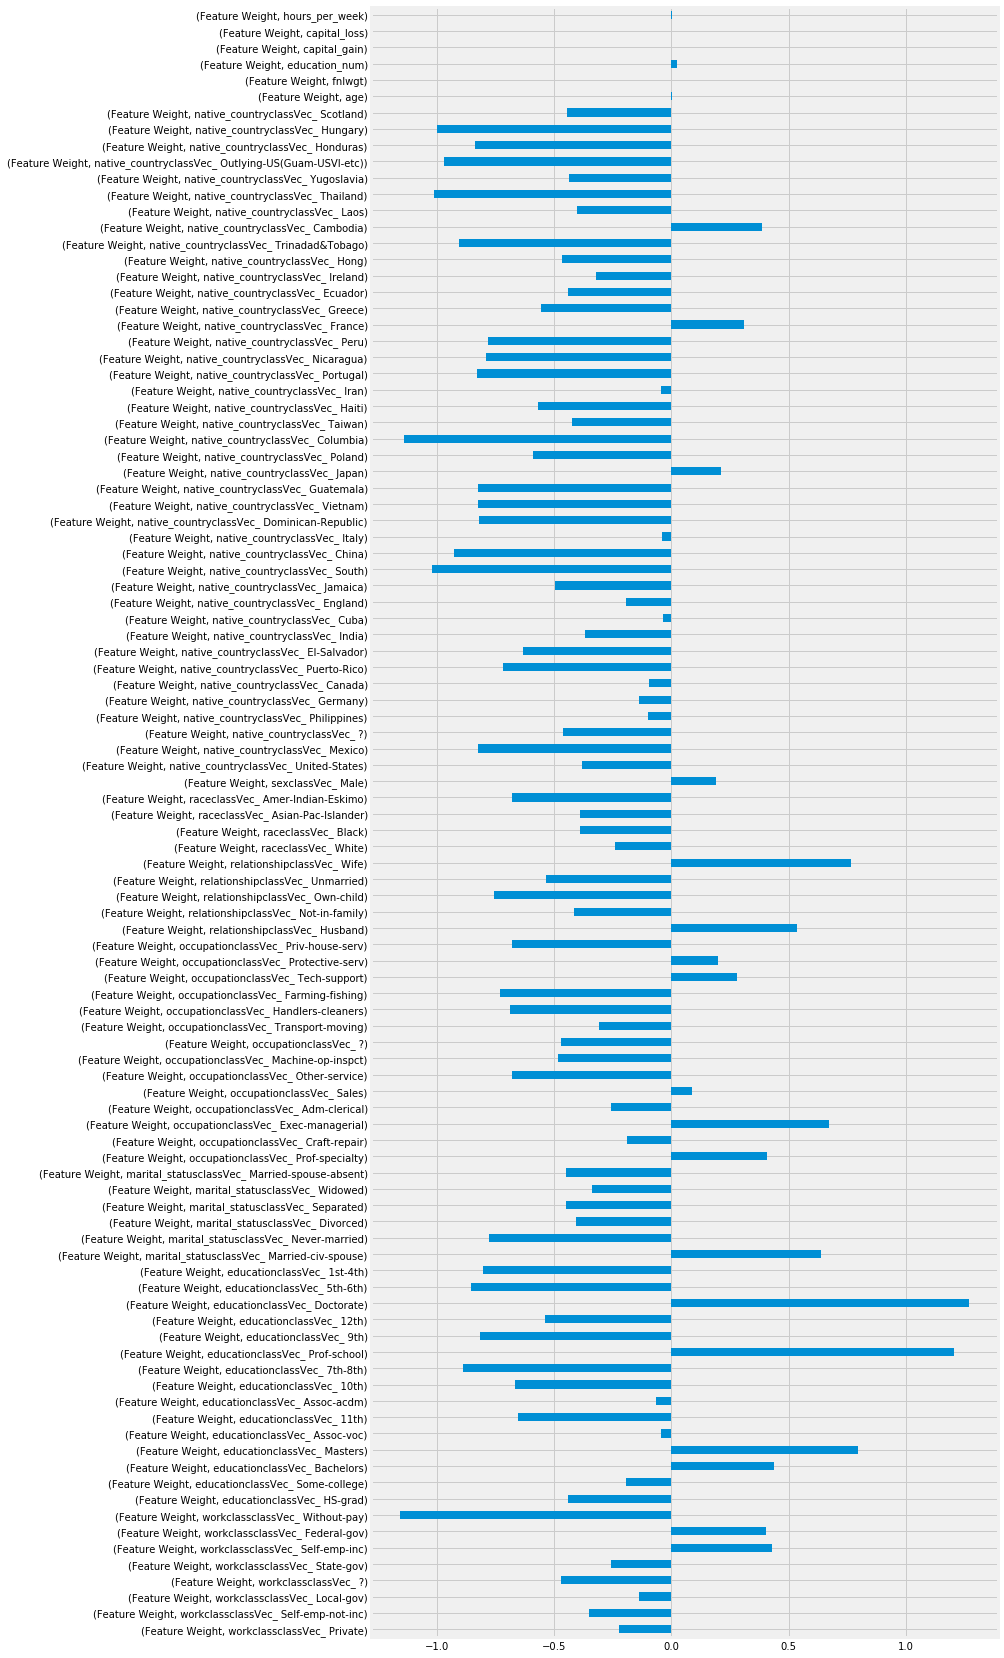

In [77]:
# do a horizontal bar graph of feature weights to visualize
f, a = plt.subplots(1, 1, figsize=(10, 30))
lrFeatureWeightDF.unstack().plot(kind='barh', y='Feature Weight')

# Your Turn: Q10: Build and train a RandomForestClassifier and print out a table of feature importances from it

In [63]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=1)
rfParamGrid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [20, 40, 80])
               .addGrid(rf.maxBins, [16, 32, 64])
               .addGrid(rf.maxDepth, [1, 5, 10])
               .build()
              )

rfCv = CrossValidator(estimator=rf, estimatorParamMaps=rfParamGrid, evaluator=evaluator, numFolds=3)
rfCvModel = rfCv.fit(trainingData)

In [64]:
rfCvModel.bestModel.extractParamMap()


{Param(parent='RandomForestClassifier_46f7f19652ad', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_46f7f19652ad', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_46f7f19652ad', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_46f7f19652ad', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_46f7f19652ad', 

In [65]:
rfCvPredictions = rfCvModel.transform(testData)


In [66]:
# let's see summary of predictions
print_performance_metrics(rfCvPredictions)


auc = 0.9064870354983758
aupr = 0.776834294403397
Area under PR = 0.6690165139270061
Area under ROC = 0.7485667134630261
Accuracy = 0.8540573896945387
DenseMatrix([[7016.,  332.],
             [1087., 1288.]])
F1 = 0.7764836457843355
Precision = 0.8304569409592241
Recall = 0.7485667134630261
FPR = 0.2514332865369739
TPR = 0.7485667134630261


In [83]:
rfCvModel.bestModel.featureImportances.toArray()

array([1.71801566e-03, 3.33272621e-03, 7.71393362e-04, 1.24175806e-03,
       8.12661486e-04, 4.65361055e-03, 2.77941852e-03, 1.51379616e-05,
       9.21250434e-03, 2.13996672e-03, 2.26979830e-02, 1.55159939e-02,
       8.40352301e-04, 1.39865751e-03, 3.82631980e-04, 1.31074030e-03,
       1.65936241e-03, 1.05506384e-02, 9.11458774e-04, 1.72753800e-04,
       4.22626386e-03, 5.00138338e-04, 6.67400216e-05, 1.30991117e-01,
       6.09525511e-02, 8.83372140e-03, 1.58041442e-03, 1.10013911e-03,
       5.32697173e-04, 2.07574717e-02, 2.21620086e-03, 2.96211783e-02,
       1.56510770e-03, 1.35037560e-03, 9.22393568e-03, 1.07197646e-03,
       8.91259765e-04, 8.97194562e-04, 1.77962657e-03, 2.95381259e-03,
       2.45959845e-03, 5.48077815e-04, 5.13645014e-05, 1.25910966e-01,
       2.14577790e-02, 1.97179339e-02, 1.02590460e-02, 1.70802652e-02,
       3.02376141e-03, 1.42741781e-03, 8.49486981e-04, 3.51873306e-04,
       2.11333036e-02, 1.74042749e-03, 1.28637781e-03, 6.91934430e-04,
      

In [111]:
rfFeatureImportance = pd.DataFrame(rfCvModel.bestModel.featureImportances.toArray()).rename({0: "Importance"}, axis='columns')
rfFeatureImportance.describe()

,Importance
count,100.000000
mean,0.010000
std,0.026755
min,0.000000
25%,0.000165
50%,0.000827
75%,0.003101
max,0.140858


In [112]:
# get feature names so we can merge with the feature importance for RF
attrs_df = pd.DataFrame(attrs.items()).sort_values(0).set_index(0).rename({1: "Feature Name"}, axis='columns')

In [114]:
rfFeatures = attrs_df.join(rfFeatureImportance)
rfFeatures

,Feature Name,Importance
0,,
0,workclassclassVec_ Private,0.001718
1,workclassclassVec_ Self-emp-not-inc,0.003333
2,workclassclassVec_ Local-gov,0.000771
3,workclassclassVec_ ?,0.001242
4,workclassclassVec_ State-gov,0.000813
5,workclassclassVec_ Self-emp-inc,0.004654
6,workclassclassVec_ Federal-gov,0.002779
7,workclassclassVec_ Without-pay,0.000015
8,educationclassVec_ HS-grad,0.009213


# Analysis

Feature importance for RF is the node impurity weighted by the probability of reaching that node.

For RF, the last 6 variables (hours_per_week to age) seem to be pretty important - however, these were not importance in LR as the weights were close to 0.

Native country don't seem to be important factors in RF decision trees whereas these had eithe relatively high (+/-) values in LR

The following seems to be big decision factors when using RF:
* husband
* married vs not married

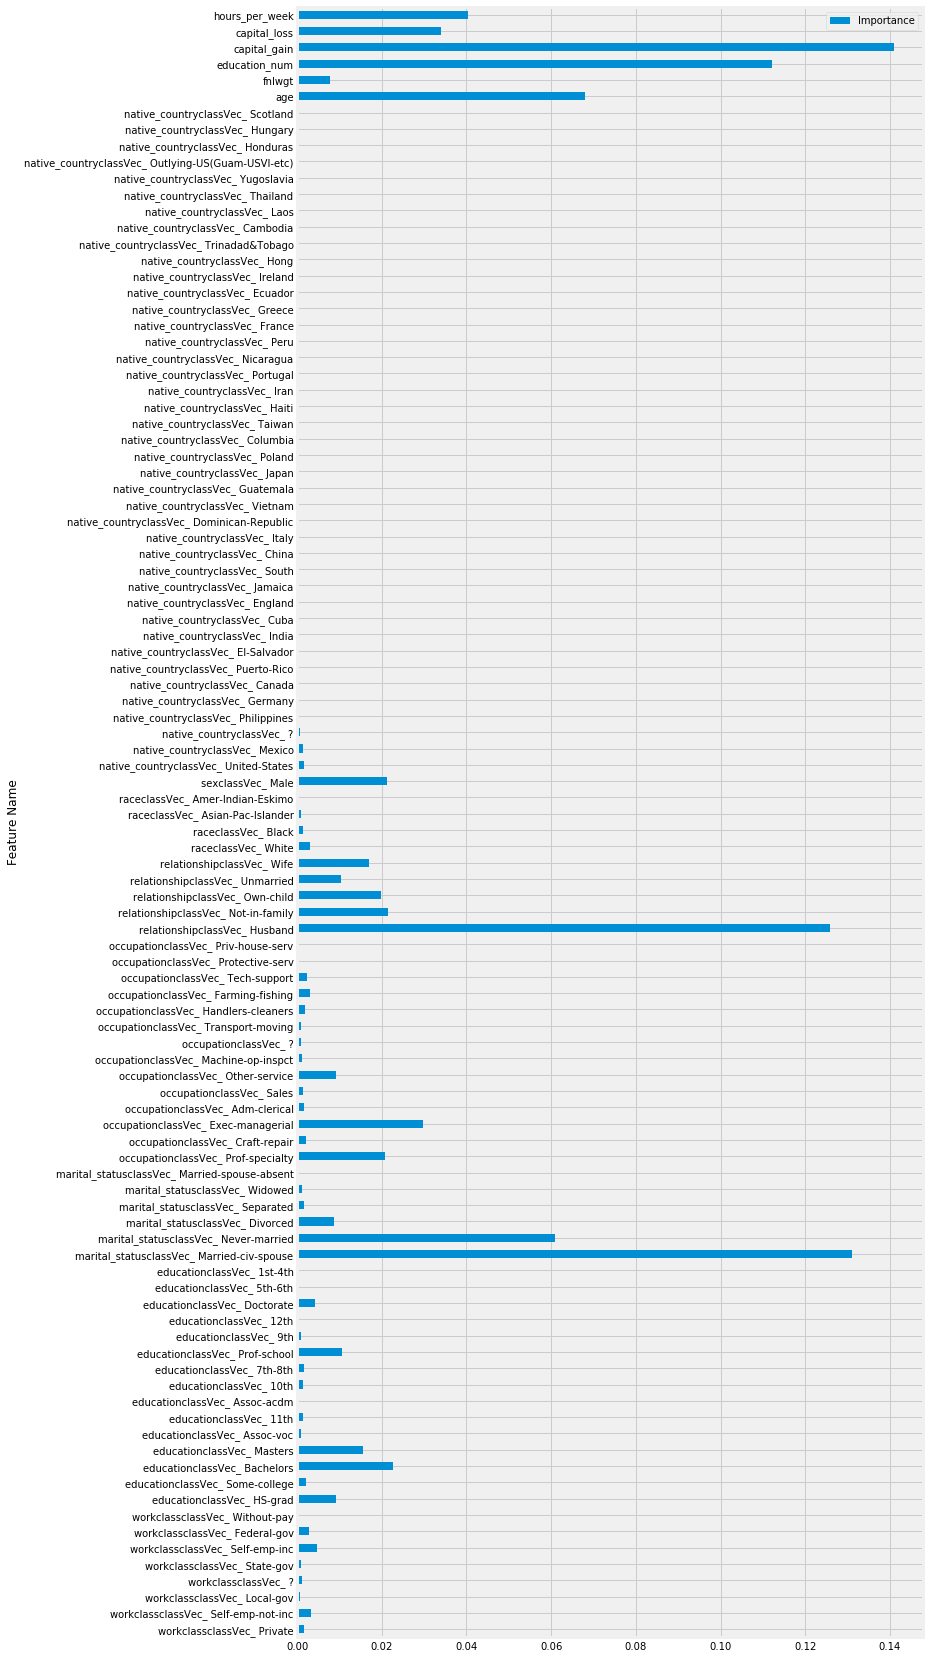

In [109]:
f, a = plt.subplots(1, 1, figsize=(10, 30))
rfFeatures.plot(kind='barh', y="Importance", x="Feature Name", ax=a)